In [3]:
from __future__ import absolute_import, division, print_function
import matplotlib
from keras.models import Sequential, model_from_json
from sklearn.metrics import mean_squared_error
import os
import argparse
import csv
from CondDelayDist_funs import *
from extractDataset_SingleQ_LES import rho, N, c_a, TotHistLength
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from eli5.permutation_importance import get_score_importances

In [4]:
def plot_history(history):
        fig = plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.plot(history.epoch, np.array(history.history['loss']),
                 label='Train Loss')
        plt.plot(history.epoch, np.array(history.history['val_loss']),
                 label='Val loss')
        plt.legend()
        fig_path = fig_directory + '/trainValError %s_%s_%d (rho %3.2f).pdf' % (ArrivalType, ServiceType, N, rho)
        fig.savefig(fig_path, bbox_inches='tight')


# Model
def build_model(learning_rate):
    model = Sequential([
        Dense(64, activation=tf.nn.relu, input_shape=(train_data.shape[1],)),
        # Dense(64, activation=tf.nn.relu),
        Dense(32, activation=tf.nn.relu),
        Dense(1, activation=tf.nn.relu),
    ])
    print(model.summary())
    optimizer = tf.train.RMSPropOptimizer(learning_rate)
    model.compile(loss='mse',
                  optimizer=optimizer)
    # metrics=['mean_absolute_error']) keras.optimizers.Adam()
    return model

def score(X, y):
    y_pred = model.predict(X)
    return -mean_squared_error(y_pred, y)

class PrintDot(Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')


# Initialization

In [5]:
learning = 1  # set to one(zero) for learning (prediction)
learning_rate_range = 10.0 ** -np.arange(4,  4.5, 0.5)

# ArrivalType = arguments.ArrivalType  # Passenger or 'M' or 'H2'
ArrivalType = 'NonHomPoisson'
# ServiceType = arguments.ServiceType  # M or logNorm
ServiceType = 'logNorm'
# future_step = arguments.future_step
future_step = 1
delayHistLength = 1
feature_num = 1
mean_Ts = 1.0
mean_Ta = mean_Ts / (N * rho)
output_dim = 1
batch_size = 512
Epochs = 300
plot_flag = 1
matlab_mode = (learning == 0)
data_gen = 'queue'

if matlab_mode == 1:
    import matlab.engine
    eng = matlab.engine.start_matlab()

directory = 'Queueing_FeedForward_pred/%s_%s/stepsAhead %d' % (ArrivalType, ServiceType, future_step)
data_directory = 'Queueing_models_RNN_MDN/%s_%s' % (ArrivalType, ServiceType)
if not os.path.exists(directory):
    os.makedirs(directory)


# Dataset preperation

In [6]:
# \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
if data_gen == 'dist' and ArrivalType == 'M':
    if learning:
        w = np.random.uniform(0.0, 10.0, 250)
        dataSet = data_gen_dist_based(w, N, mean_Ta, mean_Ts)
        w = np.random.uniform(0.0, 10.0, 30)
        testdata = data_gen_dist_based(w, N, mean_Ta, mean_Ts)
        with open(directory + '/dataset/DelayPredTrainingdata_distGen.csv', 'w') as csvFile:
            writer = csv.writer(csvFile)
            writer.writerows(dataSet)

        csvFile.close()
        with open(directory + '/dataset/DelayPredTestdata_distGen.csv', 'w') as csvFile:
            writer = csv.writer(csvFile)
            writer.writerows(testdata)
        csvFile.close()
    else:
        dataSet = np.genfromtxt(directory + '/dataset/DelayPredTrainingdata_distGen.csv', delimiter=',')
        testdata = np.genfromtxt(directory + '/dataset/DelayPredTestdata_distGen.csv', delimiter=',')


elif data_gen == 'queue':
    dataSet = np.genfromtxt(data_directory+'/dataset/DelayPredTrainingdata.csv', delimiter=',')  # without QLs
    Ta_train = dataSet[:, 0]
    dataSet = dataSet[:, -(feature_num * TotHistLength+1):]
    # preparing data for learning pairs of (delay, arrival time)
    temp = np.zeros((dataSet.shape[0], feature_num * TotHistLength))
    for k in range(feature_num):
        temp[:, range(k, feature_num * TotHistLength, feature_num)] = dataSet[:, k*TotHistLength:TotHistLength*(k+1)]

    # temp[:, range(0, feature_num * TotHistLength, feature_num)] = dataSet[:, -(feature_num * TotHistLength+1):-(TotHistLength+1)]
    # temp[:, range(1, feature_num * TotHistLength, feature_num)] = dataSet[:, -(TotHistLength+1):-1]  # delays

    dataSet[:, -(feature_num * TotHistLength+1):-1] = temp
    # picking a history of length #delayHistLength customers with #future_step ahead
    # dataSet = np.hstack((Ta_train.reshape(-1, 1), dataSet[:, -feature_num * delayHistLength - ((future_step-1) * feature_num + 1): - ((future_step-1) * feature_num + 1)], dataSet[:, -1].reshape(-1, 1)))
    dataSet = np.hstack((dataSet[:, -feature_num * delayHistLength - ((future_step-1) * feature_num + 1): - ((future_step-1) * feature_num + 1)], dataSet[:, -1].reshape(-1, 1)))

    testdata = np.genfromtxt(data_directory+'/dataset/DelayPredTestdata.csv', delimiter=',')  # with arrival times
    Ta_test = testdata[:, 0]  # arrival times
    testdata = testdata[:, -(feature_num * TotHistLength+1):]
    # preparing data for learning pairs of (delay, arrival time)
    temp = np.zeros((testdata.shape[0], feature_num * TotHistLength))
    for k in range(feature_num):
        temp[:, range(k, feature_num * TotHistLength, feature_num)] = testdata[:, k*TotHistLength:TotHistLength*(k+1)]
    # temp[:, range(0, feature_num * TotHistLength, feature_num)] = testdata[:, -(feature_num * TotHistLength+1):-(TotHistLength+1)]
    # temp[:, range(1, feature_num * TotHistLength, feature_num)] = testdata[:, -(TotHistLength+1):-1]
    testdata[:, -(feature_num * TotHistLength+1):-1] = temp
    # preparing for predicting #future_step ahead predictions
    # testdata = np.hstack((Ta_test.reshape(-1, 1), testdata[:, -feature_num * delayHistLength - ((future_step-1) * feature_num + 1): - ((future_step-1) * feature_num + 1)], testdata[:, -1].reshape(-1, 1)))
    testdata = np.hstack((testdata[:, -feature_num * delayHistLength - ((future_step-1) * feature_num + 1): - ((future_step-1) * feature_num + 1)], testdata[:, -1].reshape(-1, 1)))

    samplePath = np.genfromtxt(data_directory+'/dataset/samplePath.csv', delimiter=',')
    # preparing data for learning pairs of (delay, arrival time)
    Ta_samp = samplePath[:, 0]
    temp0 = samplePath[:, -(feature_num * TotHistLength+1):-1]
    temp = np.zeros_like(temp0)
    for k in range(feature_num):
        temp[:, range(k, feature_num * TotHistLength, feature_num)] = temp0[:, k*TotHistLength:TotHistLength*(k+1)]
    # temp[:, range(0, feature_num * TotHistLength, feature_num)] = temp0[:, :TotHistLength]
    # temp[:, range(1, feature_num * TotHistLength, feature_num)] = temp0[:, TotHistLength:]
    samplePath[:, -(feature_num * TotHistLength+1):-1] = temp
    # preparing for predicting #future_step ahead predictions
    # samplePath = np.hstack((Ta_samp.reshape(-1, 1), samplePath[:, -feature_num * delayHistLength - ((future_step-1) * feature_num + 1): - ((future_step-1) * feature_num + 1)]
    #                         , samplePath[:, -1].reshape(-1, 1)))
    samplePath = np.hstack((samplePath[:, -feature_num * delayHistLength - ((future_step-1) * feature_num + 1): - ((future_step-1) * feature_num + 1)]
                            , samplePath[:, -1].reshape(-1, 1)))


# Learning and/or Prediction

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________
None

....................................................................................................
....................................................................................................
....................................................................................................Saved model to disk


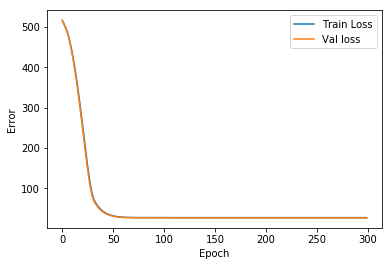

In [7]:
wLES_ind = - ((future_step-1) * feature_num+2)
# Shuffle the Dataset set
totSamples = np.shape(dataSet)[0]
order = np.argsort(np.random.random(totSamples))
dataSet = dataSet[order]

train_data = dataSet[:, :-1]
train_labels = dataSet[:, -1]
test_data = testdata[:, :-1]
test_labels = testdata[:, -1]

# Normalizing Features
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std
samplePath_inp = (samplePath[:, :-1] - mean) / std
k = 0
train_err = []
val_err = []
for learning_rate in learning_rate_range:
    fig_directory = directory + '/figs'
    model_directory = directory + '/model'
    if not os.path.exists(fig_directory):
        os.makedirs(fig_directory)
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)

    if learning:
        model = build_model(learning_rate)
        # Training
        # The patience parameter is the amount of epochs to check for improvement
        early_stop = EarlyStopping(monitor='val_loss', patience=10)
        # Store training stats
        history = model.fit(train_data, train_labels, epochs=Epochs,
                            batch_size=batch_size, validation_split=0.1, verbose=0, callbacks=[PrintDot()])

        # serialize model to JSON

        model_json = model.to_json()
        name = "/model %s_%s_%d (rho %3.2f).json" % (ArrivalType, ServiceType, N, rho)
        with open(model_directory + name, "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        name = "/weights %s_%s_%d (rho %3.2f).h5" % (ArrivalType, ServiceType, N, rho)
        model.save_weights(model_directory + name)
        print("Saved model to disk")
        train_err = np.append(train_err, np.array(history.history['loss'])[-1])
        val_err = np.append(val_err, np.array(history.history['val_loss'])[-1])
        plot_history(history)
    else:
        # load json and create model
        name = "/model %s_%s_%d (rho %3.2f).json" % (ArrivalType, ServiceType, N, rho)
        json_file = open(model_directory + name, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        # load weights into new model
        name = "/weights %s_%s_%d (rho %3.2f).h5" % (ArrivalType, ServiceType, N, rho)
        model.load_weights(model_directory + name)
        print("Loaded model from disk")
        # evaluate loaded model on test data
        model.compile(loss='mse',
                      optimizer=keras.optimizers.Adam(),
                      metrics=['mae'])


# Plotting Groundtruth vs Predictions

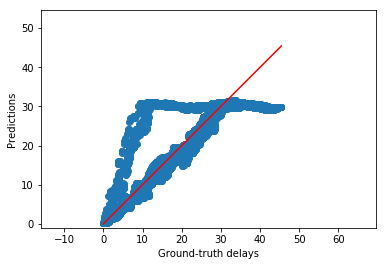

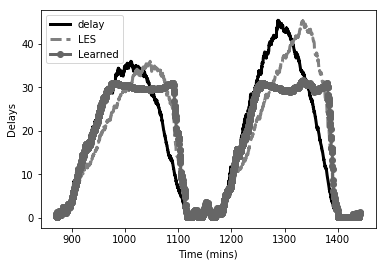

MSE_LES: 34.4857, MSE_RNN: 24.1655


In [11]:
# ///////////////////////////////Sampling from test_data for plotting//////////////////////
train_len = np.shape(train_data)[0]
test_len = np.shape(test_data)[0]
sampled_data = np.zeros((1, testdata.shape[1]))
nbins = 10
sampleNum = 100
num_per_bin = int(sampleNum / nbins)
bins = np.linspace(0, max(testdata[:, wLES_ind]), nbins + 1)
for i in range(1, nbins + 1):
    temp = np.arange(testdata.shape[0])[np.digitize(testdata[:, wLES_ind], bins) == i]
    if len(temp) > 0:
        choose = np.random.choice(temp, min(num_per_bin, len(temp)), replace=False)
        sampled_data = np.append(sampled_data, testdata[choose, :], axis=0)
plot_data = sampled_data[1:, :]
plot_data_norm = (plot_data[:, :-1] - mean) / std
sample_len = plot_data.shape[0]
# ///////////////////////////////////////////////////////////////////////////////////
test_pred = model.predict(plot_data_norm)

index_sorted_data = np.argsort(plot_data[:, wLES_ind])
sorted_data = plot_data[:, wLES_ind][index_sorted_data]
sorted_label = plot_data[index_sorted_data, -1]

nbins = 30

z_sim, x_sim, y_sim = np.histogram2d(dataSet[:, -1].flatten(), dataSet[:, wLES_ind].flatten(), nbins, normed='True')
# \\\\\\\\\\\\\\Normalization for getting the conditional distribution\\\\\\\\\
eps = 10**-15
z_sim = z_sim/(np.sum(z_sim, axis=0, keepdims=True)+eps)
# \\\\\\calculating centers of the bins\\\\\\
x_sim = (x_sim[:-1]+x_sim[1:])/2.0
y_sim = (y_sim[:-1]+y_sim[1:])/2.0
# \\\\\\\\\\\\\Making it ready for the meshplot\\\\\\\\\\\\\
x_sim = np.tile(x_sim.reshape(-1, 1), (1, nbins))
y_sim = np.tile(y_sim.reshape(1, -1), (nbins, 1))
# \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
if matlab_mode:
    x_sim_m = matlab.double(x_sim.tolist())
    y_sim_m = matlab.double(y_sim.tolist())
    z_sim_m = matlab.double(z_sim.tolist())
    h = eng.figure()
    eng.mesh(x_sim_m, y_sim_m, z_sim_m)
    eng.xlabel('delay')
    eng.ylabel('LES delay')
    eng.title('PDF (Simulated)')
    fig_path = fig_directory + '/PDF(Simulated) %s_%s_%d (rho %3.2f).fig' % (ArrivalType, ServiceType, N, rho)
    eng.savefig(fig_path, nargout=0)
# \\\\\\\\\\\\\\\\\\\\\\\SCATTER PLOT FOR PREDICTIOMNS////////////////////////
test_pred = model.predict(test_data)
min_range, max_range = min(min(test_labels), min(test_pred)), max(max(test_labels), max(test_pred))
fig = plt.figure()
ax = plt.subplot(111)
plt.scatter(test_labels, test_pred)
plt.xlabel('Ground-truth delays')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim([-1, 1.2 * max_range])
plt.ylim([-1, 1.2 * max_range])
plt.plot([min_range, max_range], [min_range, max_range], 'r')
# mse = mean_squared_error(test_labels, predictions)
# props = dict(boxstyle='round', facecolor='White', alpha=0.5)
# textstr = 'MSE: %.3f' % mse
# ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
#         verticalalignment='top', bbox=props)
fig_path = fig_directory + '/Scatterplot %s_%s_%d (rho %3.2f).pdf' % (ArrivalType, ServiceType, N, rho)
fig.savefig(fig_path, bbox_inches='tight')
# /////////////////////////////////PLOTTING A SAMPLE PATH/////////////////////////////////////////////
samplePath_predictions = model.predict(samplePath_inp)

fig = plt.figure()
plt.plot(Ta_samp, samplePath[:, -1], c='k', lw=3., label='delay')
plt.plot(Ta_samp, samplePath[:, wLES_ind], c='0.5', lw=3., ls='--', label='LES')
plt.plot(Ta_samp, samplePath_predictions, c='0.4', marker='o', lw=3., label='Learned')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('Delays')
if plot_flag: plt.show()
fig_path = fig_directory + '/delayVStime %s_%s_%d (rho %3.2f).pdf' % (ArrivalType, ServiceType, N, rho)
fig.savefig(fig_path, bbox_inches='tight')
# /////////////////////////////////Comparing the efficiency of LES and RNN model////////////////////////
MSE_LES = mean_squared_error(test_labels, testdata[:, wLES_ind])
MSE_RNN = mean_squared_error(test_labels, test_pred)
print("MSE_LES: %7.4f, MSE_RNN: %7.4f" %(MSE_LES, MSE_RNN))

# Permutation importance 

In [13]:
base_score, score_decreases = get_score_importances(score, train_data, train_labels, n_iter=10)
feature_importances = np.mean(score_decreases, axis=0)
# print(feature_importances)
print(np.argsort(feature_importances))

[0]
